In [131]:
pip install catboost

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 98.7 MB 16 kB/s s eta 0:00:01
     |████████████████████████████████| 15.6 MB 105.8 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 6.7 MB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [165]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder

In [113]:
invoice_data = pd.read_excel('shared_data_read_only/Invoice and Opportunities.xlsx')
non_stock_data = pd.read_excel('shared_data_read_only/Non-Stock Items.xlsx')
item_data = pd.read_excel('shared_data_read_only/Items and Opportunities.xlsx')
opportunities_data = pd.read_excel('shared_data_read_only/Opportunities.xlsx')
contacts_data = pd.read_excel('shared_data_read_only/Contacts.xlsx')
accounts_data = pd.read_excel('shared_data_read_only/Business Account.xlsx')
cpi_data = pd.read_excel('shared_data_read_only/consumer_price_index.xlsx')

In [153]:
full_data = opportunities_data.merge(invoice_data, on='Opportunity ID')
full_data = full_data.merge(item_data, on='Opportunity ID')
full_data = full_data.merge(non_stock_data, on='Inventory ID')
full_data = full_data.merge(accounts_data, on='Business Account')
full_data = full_data.merge(contacts_data, on='Business Account')
full_data = full_data.merge(cpi_data, on='Date')

In [4]:
invoice_data.describe()

,Amount,Opportunity ID
count,3.238000e+03,3238.000000
mean,1.777426e+04,3375.605312
std,6.476494e+04,1360.644546
min,0.000000e+00,4.000000
25%,7.920000e+02,2147.250000
50%,4.000000e+03,3456.500000
75%,1.000000e+04,4457.250000
max,1.784427e+06,6241.000000


In [5]:
invoice_data.head()

,Type,Reference Nbr.,Customer,Amount,Date,Opportunity ID
0,Invoice,FC0004608,C06507,5000.0,2023-10-10,4504
1,Invoice,FC0004607,C01388,241253.0,2023-10-09,1863
2,Invoice,FC0004605,C19104,83954.0,2023-10-06,5708
3,Invoice,FC0004600,C10528,3000.0,2023-06-23,5617
4,Invoice,FC0004598,C01196,54531.0,2023-10-09,5829


             Amount  Opportunity ID
count  3.238000e+03     3238.000000
mean   1.777426e+04     3375.605312
std    6.476494e+04     1360.644546
min    0.000000e+00        4.000000
25%    7.920000e+02     2147.250000
50%    4.000000e+03     3456.500000
75%    1.000000e+04     4457.250000
max    1.784427e+06     6241.000000
Type              0
Reference Nbr.    0
Customer          0
Amount            0
Date              0
Opportunity ID    0
dtype: int64
Invoice    3238
Name: Type, dtype: int64
C00366    44
C00644    32
C01196    24
C00665    20
C00094    18
          ..
C00101     1
C04583     1
C06923     1
C00552     1
C12203     1
Name: Customer, Length: 1257, dtype: int64


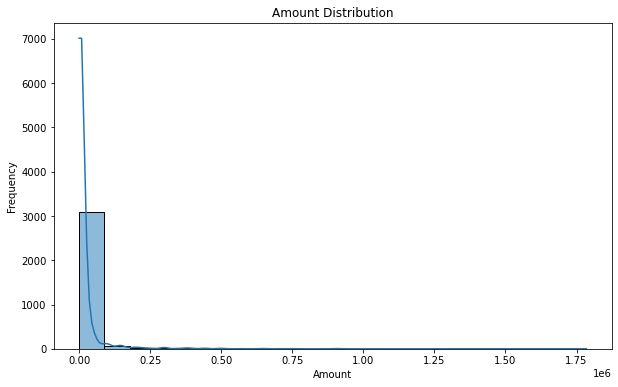

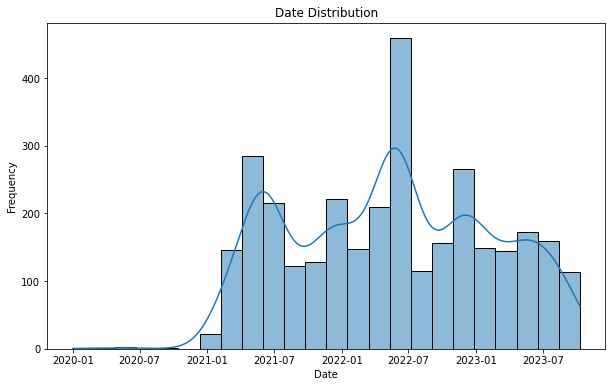

4043    15
3533    13
4148     8
1549     8
1651     8
        ..
3587     1
4297     1
3589     1
1542     1
2047     1
Name: Opportunity ID, Length: 2745, dtype: int64


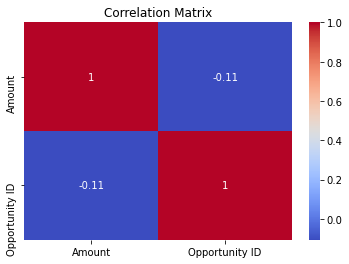

In [6]:
summary = invoice_data.describe()
print(summary)

missing_values = invoice_data.isnull().sum()
print(missing_values)

type_distribution = invoice_data['Type'].value_counts()
print(type_distribution)

customer_distribution = invoice_data['Customer'].value_counts()
print(customer_distribution)

plt.figure(figsize=(10, 6))
sns.histplot(invoice_data['Amount'], bins=20, kde=True)
plt.title('Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()

invoice_data['Date'] = pd.to_datetime(invoice_data['Date'])
plt.figure(figsize=(10, 6))
sns.histplot(invoice_data['Date'], kde=True)
plt.title('Date Distribution')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.show()

opportunity_distribution = invoice_data['Opportunity ID'].value_counts()
print(opportunity_distribution)

correlation_matrix = invoice_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [7]:
opportunities_data.head()

,Opportunity ID,Business Account,Contact ID,Estimated Close Date,Status,Stage,Probability,Estimated amount,Amount received,Difference,...,Theorical payment amount 3,Theorical payment date 4,Theorical payment amount 4,Theorical payment date 5,Theorical payment amount 5,Created On,Last Modified Date,Actual Close Date,Assignment Date,Branch ID
0,6387,C00037,35334.0,2023-11-27,New,Won,100,9000.0,NaN,-9000.0,...,NaN,NaT,NaN,NaT,NaN,2023-10-11 10:59:07.310,2023-10-11 10:59:07.310,NaT,2023-10-11 10:58:16.137,SDLV
1,6386,C01254,36240.0,2023-10-11,New,Won,100,9000.0,NaN,-9000.0,...,NaN,NaT,NaN,NaT,NaN,2023-10-11 10:55:50.773,2023-10-11 10:55:50.773,NaT,2023-10-11 10:53:26.857,SDLV
2,6385,C21512,47640.0,2023-10-11,New,Oral agreement,80,140.0,NaN,-140.0,...,NaN,NaT,NaN,NaT,NaN,2023-10-11 08:53:52.533,2023-10-11 08:54:37.860,NaT,2023-10-11 08:52:52.257,SDLV
3,6384,C21509,47636.0,2023-10-11,New,Oral agreement,80,350.0,NaN,-350.0,...,NaN,NaT,NaN,NaT,NaN,2023-10-11 08:42:41.140,2023-10-11 08:42:41.140,NaT,2023-10-11 08:41:27.513,SDLV
4,6383,C21508,47635.0,2023-10-10,New,Oral agreement,80,120.0,NaN,-120.0,...,NaN,NaT,NaN,NaT,NaN,2023-10-10 15:54:31.827,2023-10-10 15:56:12.527,NaT,2023-10-10 15:53:17.550,SDLV


In [8]:
opportunities_data.columns

Index(['Opportunity ID', 'Business Account', 'Contact ID',
       'Estimated Close Date', 'Status', 'Stage', 'Probability',
       'Estimated amount', 'Amount received', 'Difference', 'Owner Name',
       'Follow-up with', 'Class ID', 'Class', 'Source', 'Source Campaign',
       'Campaign Name', 'Programme financé', 'Action financée', 'Agreement',
       'Signature date of the agreement', 'Agreement expiry date',
       'Duration of agreement (months)',
       'Deadline for submission of interim report', 'Final report deadline',
       'Type de contrat', 'Type de financement', 'Zone SDLV',
       'Theorical payment date 1', 'Theorical payment amount 1',
       'Theorical payment date 2', 'Theorical payment amount 2',
       'Theorical payment date 3', 'Theorical payment amount 3',
       'Theorical payment date 4', 'Theorical payment amount 4',
       'Theorical payment date 5', 'Theorical payment amount 5', 'Created On',
       'Last Modified Date', 'Actual Close Date', 'Assignment Da

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 43 columns):
 #   Column                                     Non-Null Count  Dtype         
---  ------                                     --------------  -----         
 0   Opportunity ID                             5986 non-null   int64         
 1   Business Account                           5984 non-null   object        
 2   Contact ID                                 2791 non-null   float64       
 3   Estimated Close Date                       5986 non-null   datetime64[ns]
 4   Status                                     5986 non-null   object        
 5   Stage                                      5986 non-null   object        
 6   Probability                                5986 non-null   int64         
 7   Estimated amount                           5986 non-null   float64       
 8   Amount received                            2736 non-null   float64       
 9   Difference         

/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


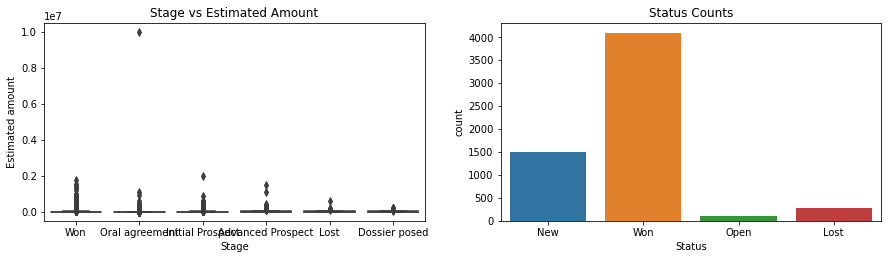

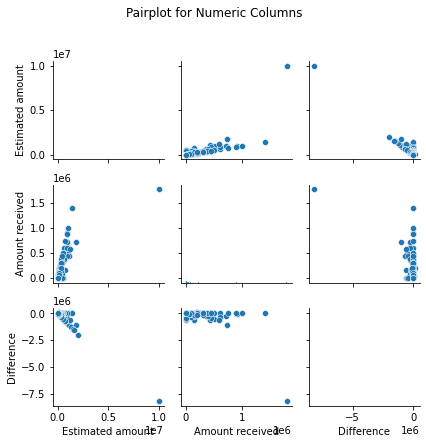

Text(0.5, 1.0, 'Correlation Heatmap')

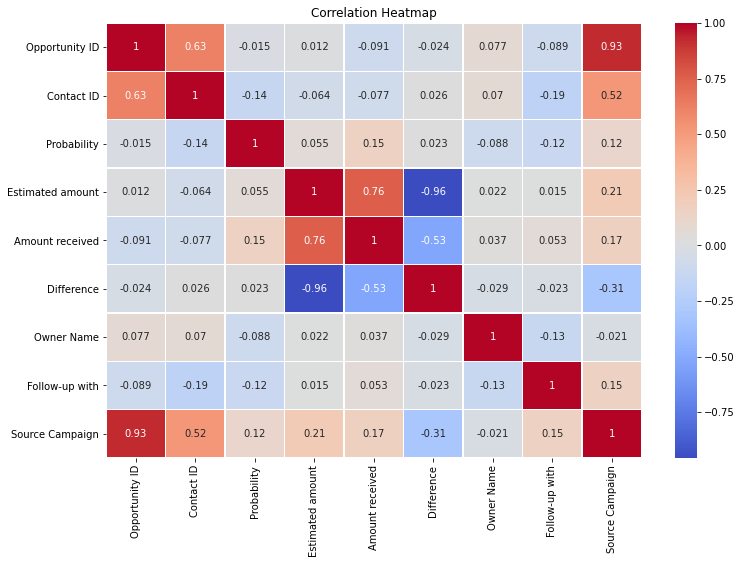

In [42]:
print(opportunities_data.info())

print(opportunities_data.head())

print(opportunities_data.describe())

print(opportunities_data.isnull().sum())

plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
sns.boxplot(x='Stage', y='Estimated amount', data=opportunities_data)
plt.title('Stage vs Estimated Amount')

plt.subplot(2, 2, 2)
sns.countplot(opportunities_data['Status'])
plt.title('Status Counts')

numeric_cols = ['Estimated amount', 'Amount received', 'Difference']
sns.pairplot(opportunities_data[numeric_cols], height=2)
plt.suptitle('Pairplot for Numeric Columns', y=1.02)

plt.tight_layout()
plt.show()

correlation_matrix = opportunities_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')

# plt.savefig('eda_visualizations.png')
# data.to_csv('cleaned_data.csv', index=False)


In [43]:
joined_data = accounts_data.merge(opportunities_data, on='Business Account')

In [44]:
joined_data.columns

Index(['Business Account', 'Customer Status', 'Type', 'Partner type',
       'Class_x', 'Class Name', 'Activity sector', 'Parent Business Account',
       'Owner Name_x', 'Follow-up with_x', 'Postal Code', 'City', 'State',
       'Country ID', 'Country Name', 'Created On_x', 'Last Modified On',
       'Opportunity ID', 'Contact ID', 'Estimated Close Date', 'Status',
       'Stage', 'Probability', 'Estimated amount', 'Amount received',
       'Difference', 'Owner Name_y', 'Follow-up with_y', 'Class ID', 'Class_y',
       'Source', 'Source Campaign', 'Campaign Name', 'Programme financé',
       'Action financée', 'Agreement', 'Signature date of the agreement',
       'Agreement expiry date', 'Duration of agreement (months)',
       'Deadline for submission of interim report', 'Final report deadline',
       'Type de contrat', 'Type de financement', 'Zone SDLV',
       'Theorical payment date 1', 'Theorical payment amount 1',
       'Theorical payment date 2', 'Theorical payment amount 2'

In [18]:
summary_stats = joined_data.describe()
print(summary_stats)

data_info = joined_data.info()

missing_values = joined_data.isnull().sum()

unique_values = joined_data.nunique()

correlation_matrix = joined_data.corr()

       Owner Name_x  Follow-up with_x  Opportunity ID    Contact ID  \
count   5550.000000       1776.000000     5867.000000   2695.000000   
mean      22.060000         17.887950     3147.588205  40695.388126   
std       10.660888          8.582022     1844.488273   3750.566610   
min        1.000000          1.000000        1.000000  35255.000000   
25%       14.000000         10.000000     1495.500000  36463.500000   
50%       26.000000         19.000000     3172.000000  40833.000000   
75%       29.000000         25.000000     4759.500000  44121.000000   
max       40.000000         32.000000     6387.000000  47664.000000   

       Probability  Estimated amount  Amount received    Difference  \
count  5867.000000      5.867000e+03     2.720000e+03  5.867000e+03   
mean    160.490881      2.247753e+04     1.824997e+04 -1.401666e+04   
std     140.433420      1.575262e+05     7.539638e+04  1.272798e+05   
min       0.000000      0.000000e+00     0.000000e+00 -8.215573e+06   
25%  

Text(0.5, 1.0, 'Correlation Heatmap')

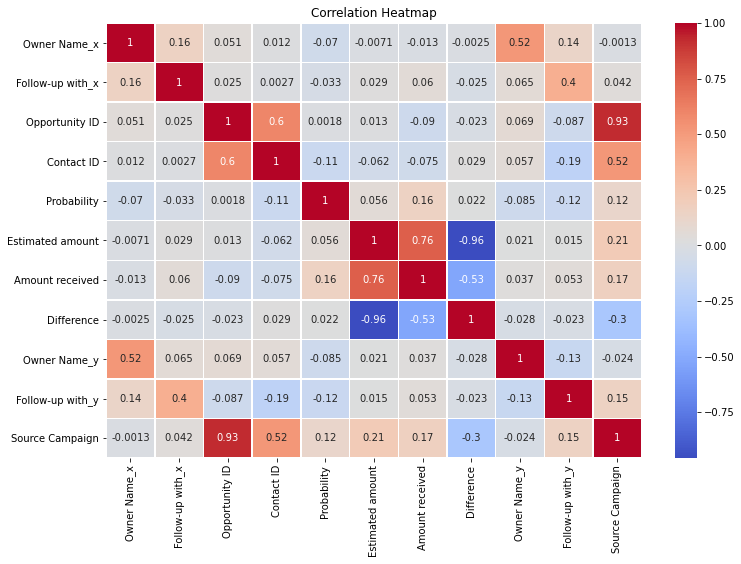

In [20]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')

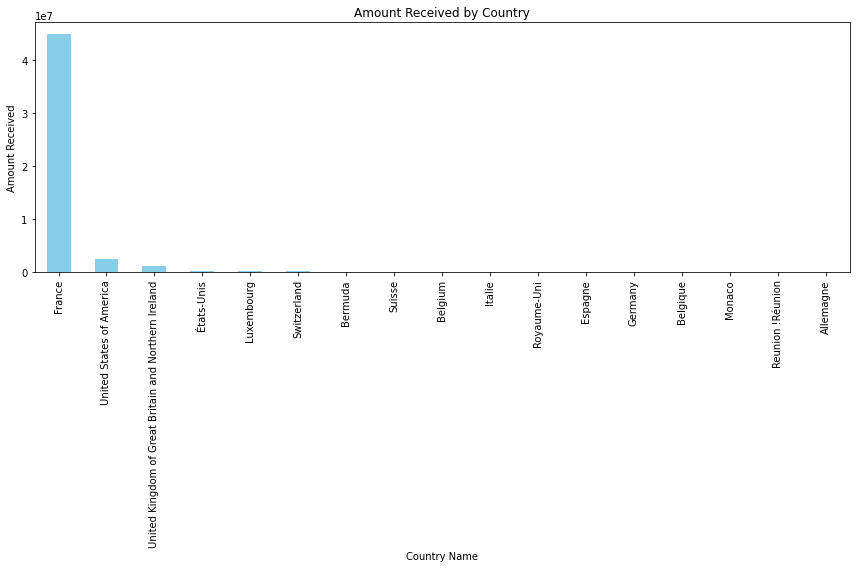

In [22]:
country_amounts = joined_data.groupby('Country Name')['Amount received'].sum()

country_amounts = country_amounts.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
country_amounts.plot(kind='bar', color='skyblue')

plt.xlabel('Country Name')
plt.ylabel('Amount Received')
plt.title('Amount Received by Country')

plt.tight_layout()
plt.show()


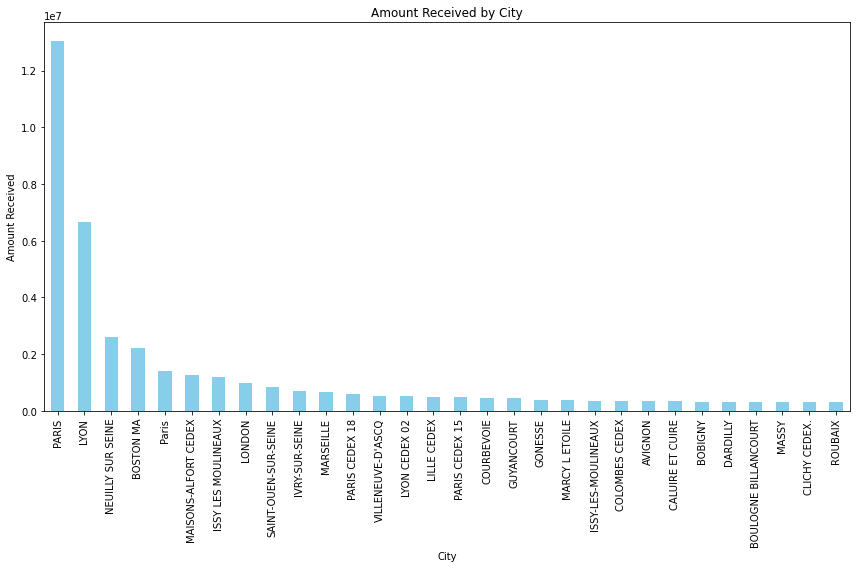

In [28]:
city_amounts = joined_data.groupby('City')['Amount received'].sum()

city_amounts = city_amounts.sort_values(ascending=False).head(30)

plt.figure(figsize=(12, 8))
city_amounts.plot(kind='bar', color='skyblue')

plt.xlabel('City')
plt.ylabel('Amount Received')
plt.title('Amount Received by City')

plt.tight_layout()
plt.show()

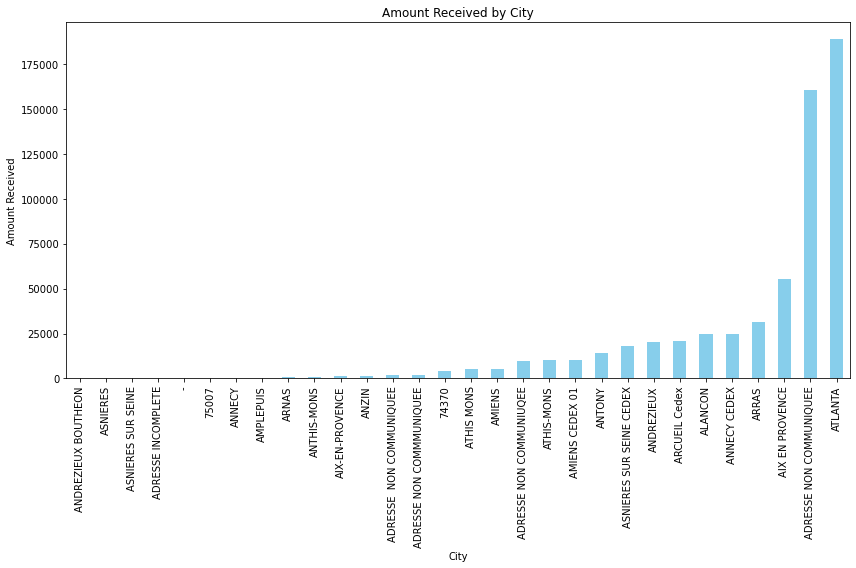

In [29]:
city_amounts = joined_data.groupby('City')['Amount received'].sum()

city_amounts = country_amounts.sort_values(ascending=True).head(30)

plt.figure(figsize=(12, 8))
city_amounts.plot(kind='bar', color='skyblue')

plt.xlabel('City')
plt.ylabel('Amount Received')
plt.title('Amount Received by City')

plt.tight_layout()
plt.show()

In [52]:
def clean_city_name(city):
    city = city.capitalize()
    city = city.replace('-', ' ')
    city = city.replace('é', 'e')
    city = city.replace('è', 'e')
    city = city.replace('cedex', '')
    city = re.sub(r'\d', '', city)
    city = city.replace("'", '')
    city = city.strip()

    return city

cleaned_data = joined_data.copy()
cleaned_data['City'] = joined_data['City'].astype('str').apply(clean_city_name)

In [54]:
cleaned_data['City'].nunique()

447

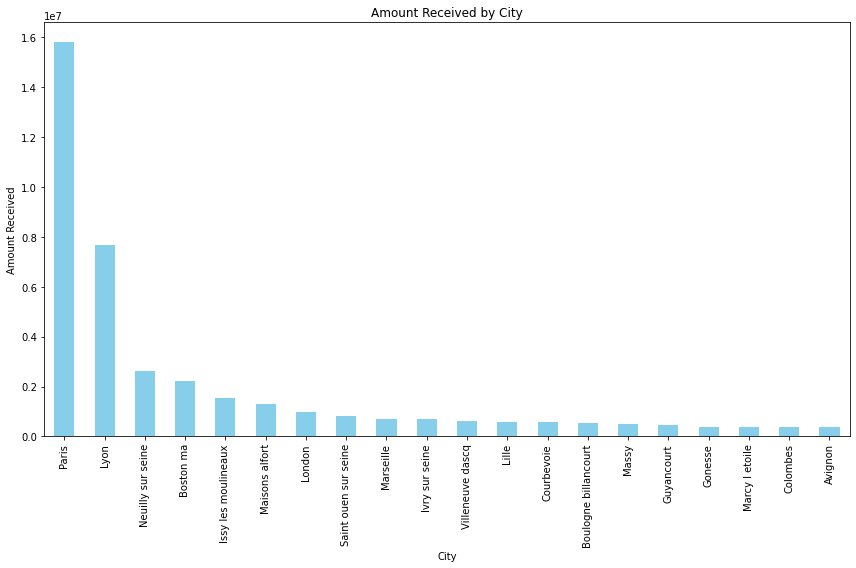

In [202]:
city_amounts = cleaned_data.groupby('City')['Amount received'].sum()

city_amounts = city_amounts.sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 8))
city_amounts.plot(kind='bar', color='skyblue')

plt.xlabel('City')
plt.ylabel('Amount Received')
plt.title('Amount Received by City')

plt.tight_layout()
plt.show()

In [65]:
joined_data['Class Name'].unique()

array(['Foundation', nan, 'Headquarters', 'Agency', 'US - United States',
       'Regional direction', 'Individual', 'Local Authority',
       'UK - United Kingdom', 'Store', 'State', 'European Union'],
      dtype=object)

In [67]:
class_amounts = joined_data.groupby('Class Name')['Amount received'].sum()

total_amount_received = joined_data['Amount received'].sum()
class_percentages = (class_amounts / total_amount_received) * 100

highest_percentage_class = class_percentages.idxmax()

print(f"The 'Class Name' with the highest percentage of the total 'Amount received' is: {highest_percentage_class}")
print(f"Highest Percentage: {class_percentages.max():.2f}%")


The 'Class Name' with the highest percentage of the total 'Amount received' is: Headquarters
Highest Percentage: 36.51%


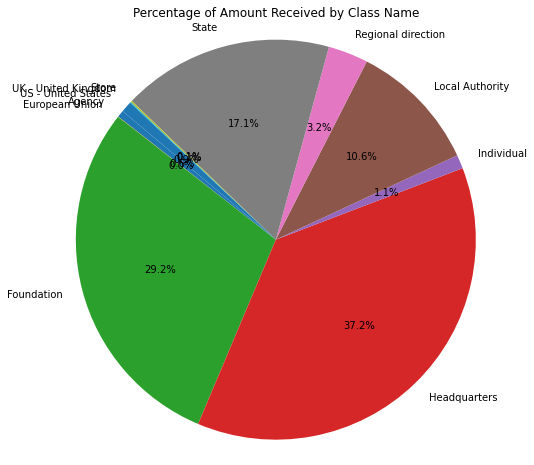

The 'Class Name' with the highest percentage of the total 'Amount received' is: Headquarters
Highest Percentage: 36.51%


In [68]:
plt.figure(figsize=(8, 8))
plt.pie(class_percentages, labels=class_percentages.index, autopct='%1.1f%%', startangle=140)

plt.title('Percentage of Amount Received by Class Name')

plt.axis('equal') 
plt.show()

print(f"The 'Class Name' with the highest percentage of the total 'Amount received' is: {highest_percentage_class}")
print(f"Highest Percentage: {class_percentages.max():.2f}%")

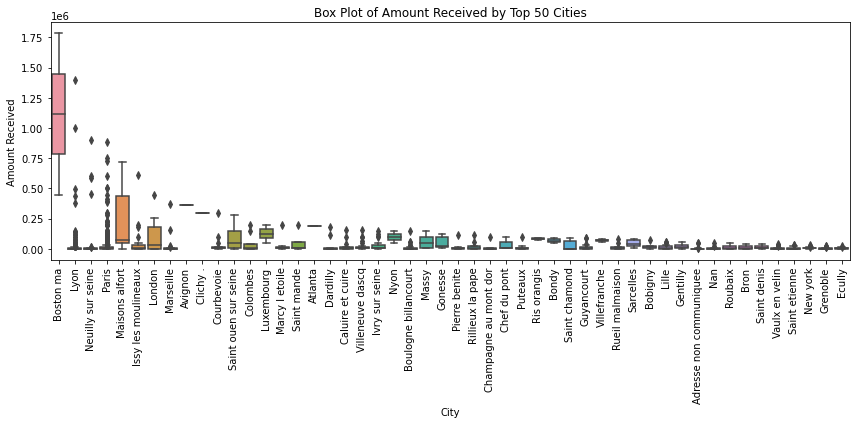

In [201]:
top_cities_count = 50 

top_cities = cleaned_data.groupby('City')['Amount received'].sum().nlargest(top_cities_count).index

filtered_data = cleaned_data[cleaned_data['City'].isin(top_cities)].sort_values(by='Amount received', ascending=False)

plt.figure(figsize=(12, 6))
sns.boxplot(x='City', y='Amount received', data=filtered_data)
plt.xticks(rotation=90)  
plt.xlabel('City')
plt.ylabel('Amount Received')
plt.title(f'Box Plot of Amount Received by Top {top_cities_count} Cities')

plt.tight_layout()
plt.show()

In [200]:
filtered_data.groupby(['City'])['Amount received'].mean().h

City
Avignon                 3.600000e+05
Bobigny                 1.493182e+04
Boston ma               1.116772e+06
Boulogne billancourt    1.266275e+04
Caluire et cuire        2.116079e+04
Clichy .                3.000000e+05
Colombes                4.637500e+04
Courbevoie              3.511171e+04
Dardilly                3.442822e+04
Gonesse                 5.371429e+04
Guyancourt              1.307341e+04
Issy les moulineaux     4.096562e+04
Ivry sur seine          3.171118e+04
Lille                   1.310684e+04
London                  1.101606e+05
Luxembourg              1.250000e+05
Lyon                    1.344367e+04
Maisons alfort          2.563503e+05
Marcy l etoile          2.082433e+04
Marseille               1.411256e+04
Massy                   5.688889e+04
Neuilly sur seine       8.455908e+04
New york                9.093015e+03
Paris                   2.712359e+04
Puteaux                 1.072162e+04
Roubaix                 1.388296e+04
Saint mande             5.350000e

In [108]:
joined_item_data = item_data.merge(opportunities_data, on='Opportunity ID').merge(non_stock_data, on='Inventory ID')

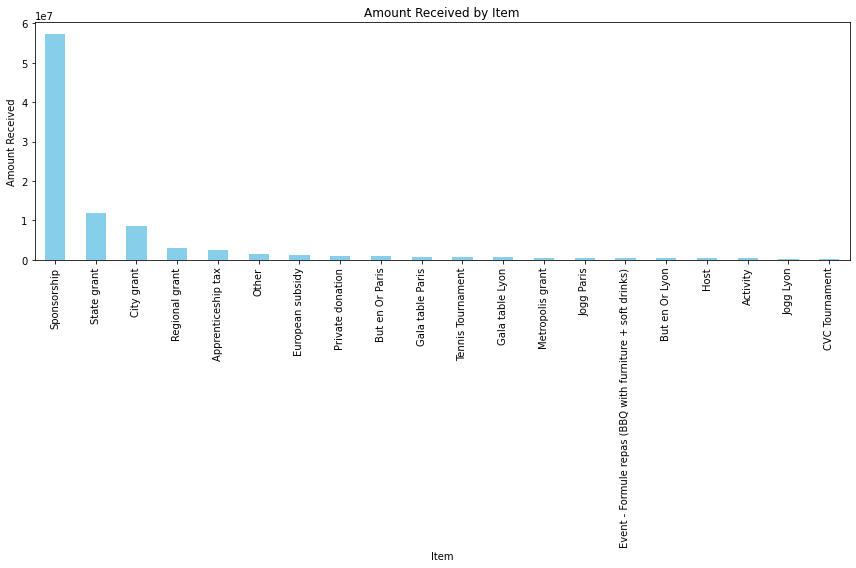

In [110]:
item_amounts = joined_item_data.groupby('Description EN')['Amount received'].sum()

item_amounts = item_amounts.sort_values(ascending=False).head(20)

plt.figure(figsize=(12, 8))
item_amounts.plot(kind='bar', color='skyblue')

plt.xlabel('Item')
plt.ylabel('Amount Received')
plt.title('Amount Received by Item')

plt.tight_layout()
plt.show()

In [154]:
full_data.dtypes

Opportunity ID                   int64
Business Account                object
Contact ID                     float64
Estimated Close Date    datetime64[ns]
Status                          object
                             ...      
Gender                          object
Client Source                   object
Last Modified On        datetime64[ns]
Created On_y            datetime64[ns]
consumer_price_index           float64
Length: 102, dtype: object